# Fit a Multi-Modal Aerosol Distribution

There are many reasons one may want to fit your SMPS/OPS/OPC data...

Here, I briefly show how to use the py-smps library to do so. Currently, support exists for fitting between 1-3 modes.


In [1]:
import smps
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random

sns.set("notebook", font_scale=1.5, palette='dark')

%matplotlib inline

print ("smps v{}".format(smps.__version__))
print ("seaborn v{}".format(sns.__version__))

smps v0.4.0
seaborn v0.7.1


## Read in the Data

First, let's read in some SMPS data. There is currently one 'sample' data set available with the py-smps library. This data was collected on an SMPS at MIT during the wintertime.

### Read in to an `SMPS` object and Plot the Histogram

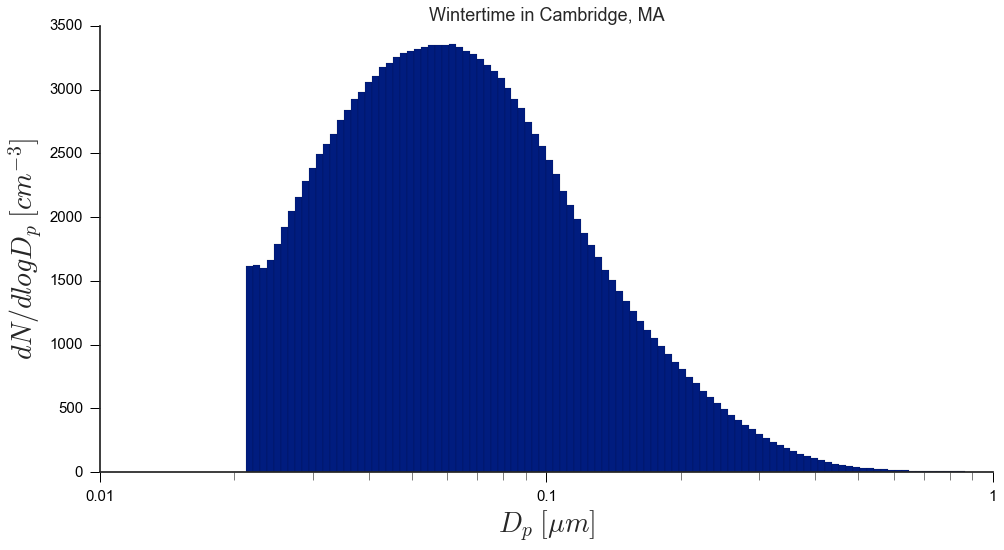

In [2]:
s = smps.io.load_sample("boston")

# plot the histogram
ax = smps.plots.histplot(s.dndlogdp, s.bins, plot_kws={'linewidth': .1})

ax.set_title("Wintertime in Cambridge, MA")

# remove the spines of the plot
sns.despine()

We went ahead and plotted the histogram of the mean values across all size bins for the entire collection period. Why? Because I can.

We see we have a single distribution with a mode of somewhere around 50-60 nm. We can go ahead and fit a simple 1-mode distribution to this data.

### Fit a Single Mode

In [3]:
# Grab the LogNormal class from the library
from smps.fit import LogNormal

# Initiate an instance of the class
model = LogNormal()

# Gather our X and Y data
X = s.midpoints
Y = s.dndlogdp.mean()

# Go ahead and fit
results = model.fit(X, Y, modes=1)

# print the results
print (results['summary'])

Mode	N (#/cc)	GM (nm)		GSD
0	2.73e+03	56.07		2.10



Now that we successfully fit our data, let's go ahead and plot it over the histogram:

### Plot Histogram with Fit Data

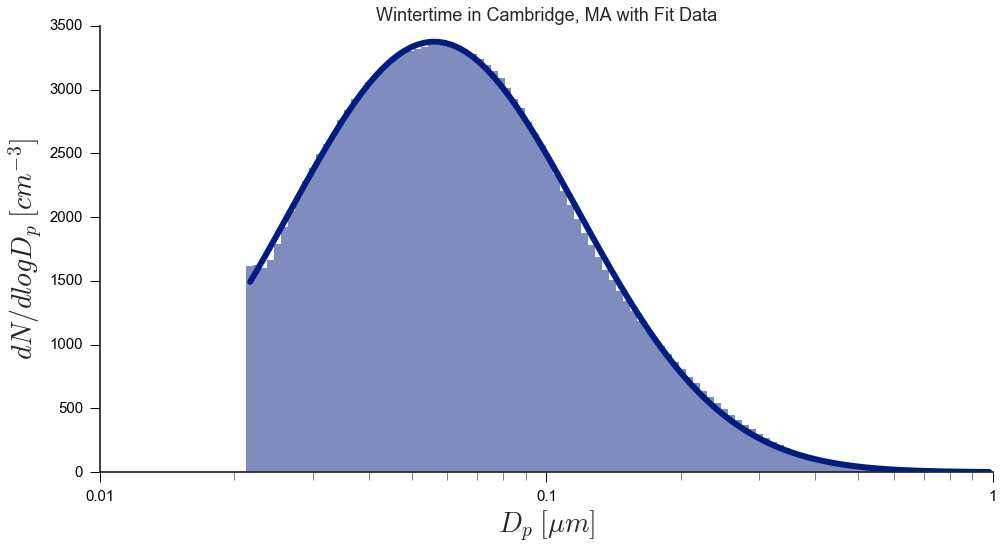

In [4]:
# plot the histogram
ax = smps.plots.histplot(s.dndlogdp, s.bins, plot_kws={'linewidth': 0., 'alpha': .5})

# Plot the fit values
ax.plot(X, results['fittedvalues'], lw=6, label="Fit Data")

ax.set_title("Wintertime in Cambridge, MA with Fit Data")

# remove the spines of the plot
sns.despine()

What else is stored in the fit results? Glad you asked!

We can go ahead and retrieve our fit parameters at `results['params']`. They are stored as an array with order [N, GM, GSD].

In [5]:
print (results['params'])

[  2.73066907e+03   5.60740983e-02   2.10235548e+00]


We can also go ahead and look at the error associated with those values at `results['error']`. They are in the same order as above.

In [6]:
print (results['error'])

[  7.30970577e+00   1.23588577e-04   5.17954866e-03]


Last, we have available another method of the `LogNormal` class which can be used after the model has been fit; it is the `predict(new_x)` method. It can be used to make predictive calculations based on your model fit. This allows you to extrapolate your fit and/or fill in missing data.  

Ex.

In [7]:
model.predict(1)

1.8359078198865233

## Plot the Missing Data

Let's use the `predict` method to fill in the lower portion of the distribution where we were not originally scanning. Is this a great idea? Well, probably not. But we can do it anyways..

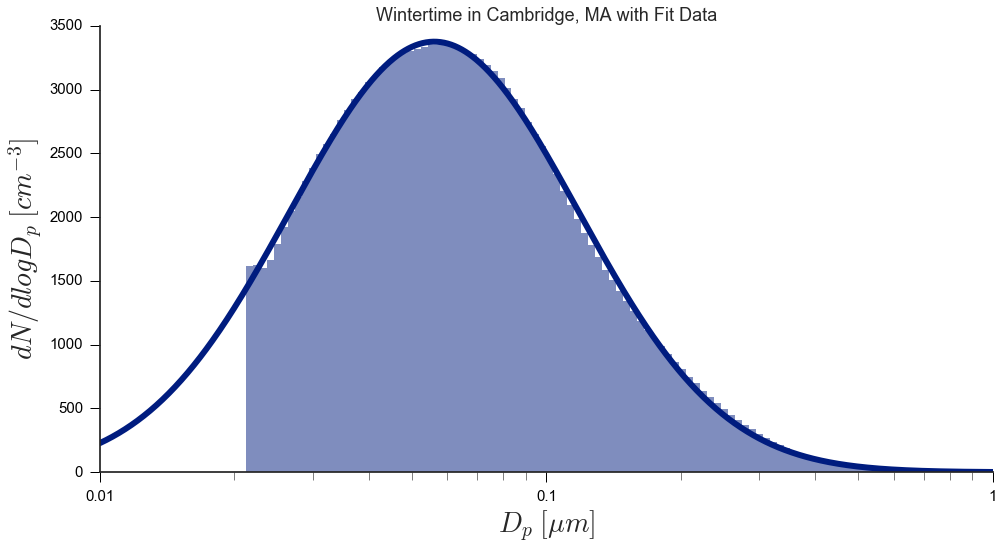

In [8]:
newX = np.logspace(np.log10(.01), np.log10(1), 1000)

# plot the histogram
ax = smps.plots.histplot(s.dndlogdp, s.bins, plot_kws={'linewidth': 0., 'alpha': .5})

# Plot the fit values
ax.plot(newX, model.predict(newX), lw=6, label="Fit Data")

ax.set_title("Wintertime in Cambridge, MA with Fit Data")

# remove the spines of the plot
sns.despine()

## Multiple Modes

I don't have access to a dataset with multiple modes in it at the moment, so we are going to fake it! We're going to mimick a multi-modal distribution and then show how to fit it. If someone wants to donate a dataset, that'd be cool!

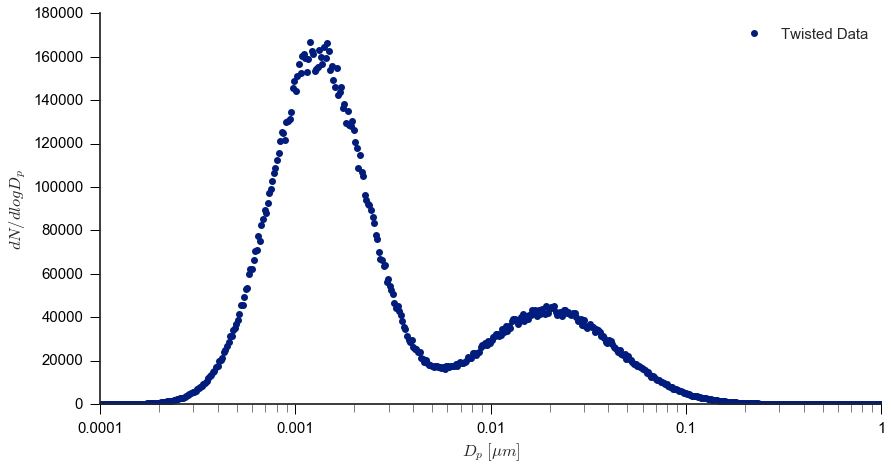

In [9]:
dp = np.logspace(np.log10(0.0001), np.log10(1), 500)

# Sample data pulled from S+P pg371
N = np.array([9.93e4, 3.64e4])
GM = np.array([1.3e-3, 20e-3])
GSD = np.array([10**.245, 10**0.336])

total = 0

for j in range(len(N)):
    total += smps.fit.dndlogdp(dp, N[j], GM[j], GSD[j])
    
# Let's confuzzle our data
twisted = total* [random.uniform(0.95, 1.05) for i in range(len(dp))]

with sns.axes_style('ticks', smps.plots.rc_log):
    fig, ax = plt.subplots(1, figsize=(14, 7))

    ax.plot(dp, twisted, 'o', label="Twisted Data")

    ax.set_xlabel("$D_p \; [\mu m]$")
    ax.set_ylabel("$dN/dlogD_p$")
    ax.semilogx()
    
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.4g"))
    ax.legend()

sns.despine()
plt.show()

Now that we have some fake data, let's go ahead and fit it! We're also going to go ahead and throw some initial guesses at it. There needs to be 3n guesses where n is the number of modes you are fitting. They should be in the order [Ni, GMi, GSDi] for i=1 to i=number of modes.

In [10]:
model = LogNormal()

X = dp
Y = twisted

# Let's set some initial guesses
p0 = [1e5, 1e-3, 2, 3e4, 20e-3, 2]

results = model.fit(X, Y, modes=2, p0=p0)

print (results['summary'])

Mode	N (#/cc)	GM (nm)		GSD
0	9.93e+04	1.30		1.76
1	3.65e+04	19.99		2.17



Now that we have our results, let's go ahead and plot them!

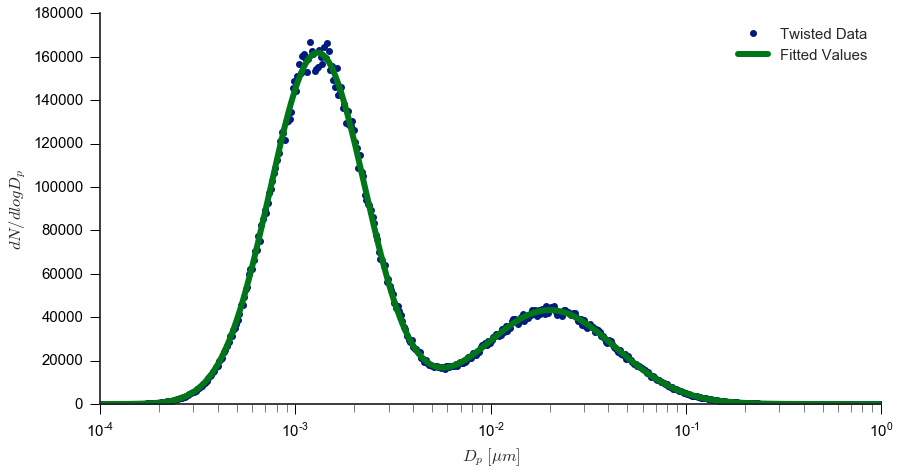

In [11]:
with sns.axes_style('ticks', smps.plots.rc_log):
    fig, ax = plt.subplots(1, figsize=(14, 7))

    ax.plot(dp, twisted, 'o', label="Twisted Data")
    ax.plot(dp, results['fittedvalues'], lw=6, label="Fitted Values")

    ax.set_xlabel("$D_p \; [\mu m]$")
    ax.set_ylabel("$dN/dlogD_p$")
    ax.semilogx()
    ax.legend()

sns.despine()
plt.show()

Last but not least...what if we only want to fit one of the modes, or fit to just a small portion of the data? Easy!

## Fit to a subset of the data

Mode	N (#/cc)	GM (nm)		GSD
0	1.02e+05	1.31		1.79



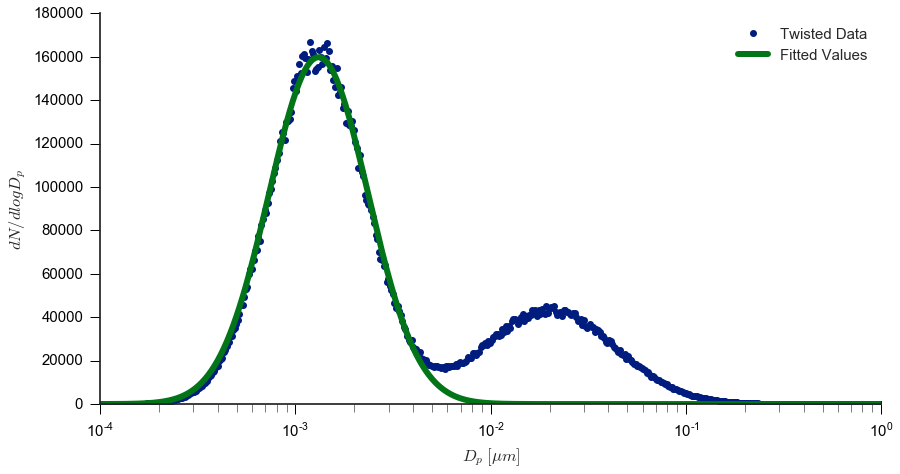

In [12]:
model = LogNormal()

X = dp
Y = twisted

results = model.fit(X, Y, modes=1, xmax=8.5)

print (results['summary'])


with sns.axes_style('ticks', smps.plots.rc_log):
    fig, ax = plt.subplots(1, figsize=(14, 7))

    ax.plot(dp, twisted, 'o', label="Twisted Data")
    ax.plot(X[X <= 8.5], results['fittedvalues'], lw=6, label="Fitted Values")

    ax.set_xlabel("$D_p \; [\mu m]$")
    ax.set_ylabel("$dN/dlogD_p$")
    ax.semilogx()
    ax.legend()

sns.despine()
plt.show()